## Part I: Data Pre-processing

In [2]:
!lsb_release -a



No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 24.04.2 LTS
Release:	24.04
Codename:	noble


In [1]:
a=9
b=a
b -= 1
print(a, b)

9 8


In [22]:
!python --version
!lscpu

Python 3.12.3


Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          52 bits physical, 57 bits virtual
  Byte Order:             Little Endian
CPU(s):                   48
  On-line CPU(s) list:    0-47
Vendor ID:                AuthenticAMD
  Model name:             AMD Ryzen Threadripper 7960X 24-Cores
    CPU family:           25
    Model:                24
    Thread(s) per core:   2
    Core(s) per socket:   24
    Socket(s):            1
    Stepping:             1
    Frequency boost:      enabled
    CPU(s) scaling MHz:   48%
    CPU max MHz:          5364.0000
    CPU min MHz:          545.0000
    BogoMIPS:             8387.68
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall
                           nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep
                          _good amd_lbr_v2 nopl xtopology nonstop_tsc cpuid extd

In [23]:
!nvidia-smi

Sat Sep 27 21:05:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.169                Driver Version: 570.169        CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5070 Ti     Off |   00000000:41:00.0 Off |                  N/A |
|  0%   36C    P1             43W /  300W |    2531MiB /  16303MiB |     16%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import pandas as pd

In [3]:
# Download the Google Analogy dataset
!wget http://download.tensorflow.org/data/questions-words.txt

--2025-09-15 23:30:45--  http://download.tensorflow.org/data/questions-words.txt
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.77.27, 142.250.198.91, 142.250.66.91, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.77.27|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 603955 (590K) [text/plain]
Saving to: ‘questions-words.txt’

questions-words.txt 100%[===================>] 589.80K  --.-KB/s    in 0.02s   

2025-09-15 23:30:45 (28.8 MB/s) - ‘questions-words.txt’ saved [603955/603955]



In [2]:
# Preprocess the dataset
file_name = "questions-words"
with open(f"{file_name}.txt", "r") as f:
    data = f.read().splitlines()

In [3]:
# check data from the first 10 entries
for entry in data[:10]:
    # if entry.startswith(": "):
    #     print("1")
    print(entry)

: capital-common-countries
Athens Greece Baghdad Iraq
Athens Greece Bangkok Thailand
Athens Greece Beijing China
Athens Greece Berlin Germany
Athens Greece Bern Switzerland
Athens Greece Cairo Egypt
Athens Greece Canberra Australia
Athens Greece Hanoi Vietnam
Athens Greece Havana Cuba


In [4]:
# TODO1: Write your code here for processing data to pd.DataFrame
# Please note that the first five mentions of ": " indicate `semantic`,
# and the remaining nine belong to the `syntatic` category.
# --- Parse `data` (list of lines) into pairs and build columns ---

questions = []
categories = []
sub_categories = []

block_idx = 0          # 已遇到的 ":" 段落數
current_cat = None     # 當前段落的分類
current_subcat = None  # 當前段落的子類別（去掉冒號）

for entry in data:
    s = str(entry).strip()
    if not s:
        continue

    if s.startswith(":"):  # 新段落
        block_idx += 1
        current_cat = "semantic" if block_idx <= 5 else "syntatic"  # 注意題目拼法
        current_subcat = s[:].strip()  # 去掉前面的冒號
        # print(current_subcat)
        continue

    # 若尚未遇到任何 ":"，略過資料行
    if current_cat is None:
        continue

    # 這裡依你的設計：整行當作一個 Question
    questions.append(s)
    categories.append(current_cat)
    sub_categories.append(current_subcat)




In [5]:
# Create the dataframe
df = pd.DataFrame(
    {
        "Question": questions,
        "Category": categories,
        "SubCategory": sub_categories,
    }
)

In [6]:
df.head(8872)

,Question,Category,SubCategory
0,Athens Greece Baghdad Iraq,semantic,: capital-common-countries
1,Athens Greece Bangkok Thailand,semantic,: capital-common-countries
2,Athens Greece Beijing China,semantic,: capital-common-countries
3,Athens Greece Berlin Germany,semantic,: capital-common-countries
4,Athens Greece Bern Switzerland,semantic,: capital-common-countries
...,...,...,...
8867,uncle aunt stepfather stepmother,semantic,: family
8868,uncle aunt stepson stepdaughter,semantic,: family
8869,amazing amazingly apparent apparently,syntatic,: gram1-adjective-to-adverb
8870,amazing amazingly calm calmly,syntatic,: gram1-adjective-to-adverb


In [7]:
df.to_csv(f"{file_name}.csv", index=False)

## Part II: Use pre-trained word embeddings
- After finish Part I, you can run Part II code blocks only.

In [8]:
!{sys.executable} -m pip install matplotlib tqdm scikit-learn seaborn


/bin/bash: line 1: {sys.executable}: command not found


In [3]:
import pandas as pd
import numpy as np
import gensim.downloader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [10]:
data = pd.read_csv("questions-words.csv")

In [12]:
MODEL_NAME = "glove-wiki-gigaword-100"
# You can try other models.
# https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models

# Load the pre-trained model (using GloVe vectors here)
model = gensim.downloader.load(MODEL_NAME)
print("The Gensim model loaded successfully!")

The Gensim model loaded successfully!


In [13]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []

for analogy in tqdm(data["Question"]):
      # TODO2: Write your code here to use pre-trained word embeddings for getting predictions of the analogy task.
      # You should also preserve the gold answers during iterations for evaluations later.
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """
      a, b, c, d = analogy.strip().split()

      # 全部轉小寫，避免 OOV
      a, b, c, d = a.lower(), b.lower(), c.lower(), d.lower()

      try:
            pred = model.most_similar(positive=[b, c], negative=[a], topn=1)[0][0]
      except KeyError:
            pred = None  # 如果還是 OOV，就跳過
      preds.append(pred)
      golds.append(d)

      # word_a, word_b, word_c, word_d = map(str.lower, analogy.split())
      # this_pred = model.most_similar([word_b, word_c], word_a, topn=1)[0][0]
      
      # preds.append(this_pred)
      # golds.append(word_d)


100%|██████████| 19544/19544 [01:20<00:00, 242.61it/s]


In [14]:
# Perform evaluations. You do not need to modify this block!!

def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds), np.array(preds)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: semantic, Accuracy: 65.3399481339497%
Category: syntatic, Accuracy: 61.255269320843084%
Sub-Category: capital-common-countries, Accuracy: 93.87351778656127%
Sub-Category: capital-world, Accuracy: 88.94783377541998%
Sub-Category: currency, Accuracy: 14.203233256351039%
Sub-Category: city-in-state, Accuracy: 30.806647750304013%
Sub-Category: family, Accuracy: 81.62055335968378%
Sub-Category: gram1-adjective-to-adverb, Accuracy: 24.39516129032258%
Sub-Category: gram2-opposite, Accuracy: 20.073891625615765%
Sub-Category: gram3-comparative, Accuracy: 79.12912912912913%
Sub-Category: gram4-superlative, Accuracy: 54.278074866310156%
Sub-Category: gram5-present-participle, Accuracy: 69.50757575757575%
Sub-Category: gram6-nationality-adjective, Accuracy: 87.86741713570981%
Sub-Category: gram7-past-tense, Accuracy: 55.44871794871795%
Sub-Category: gram8-plural, Accuracy: 71.996996996997%
Sub-Category: gram9-plural-verbs, Accuracy: 58.39080459770115%


[: family] words in model: 46


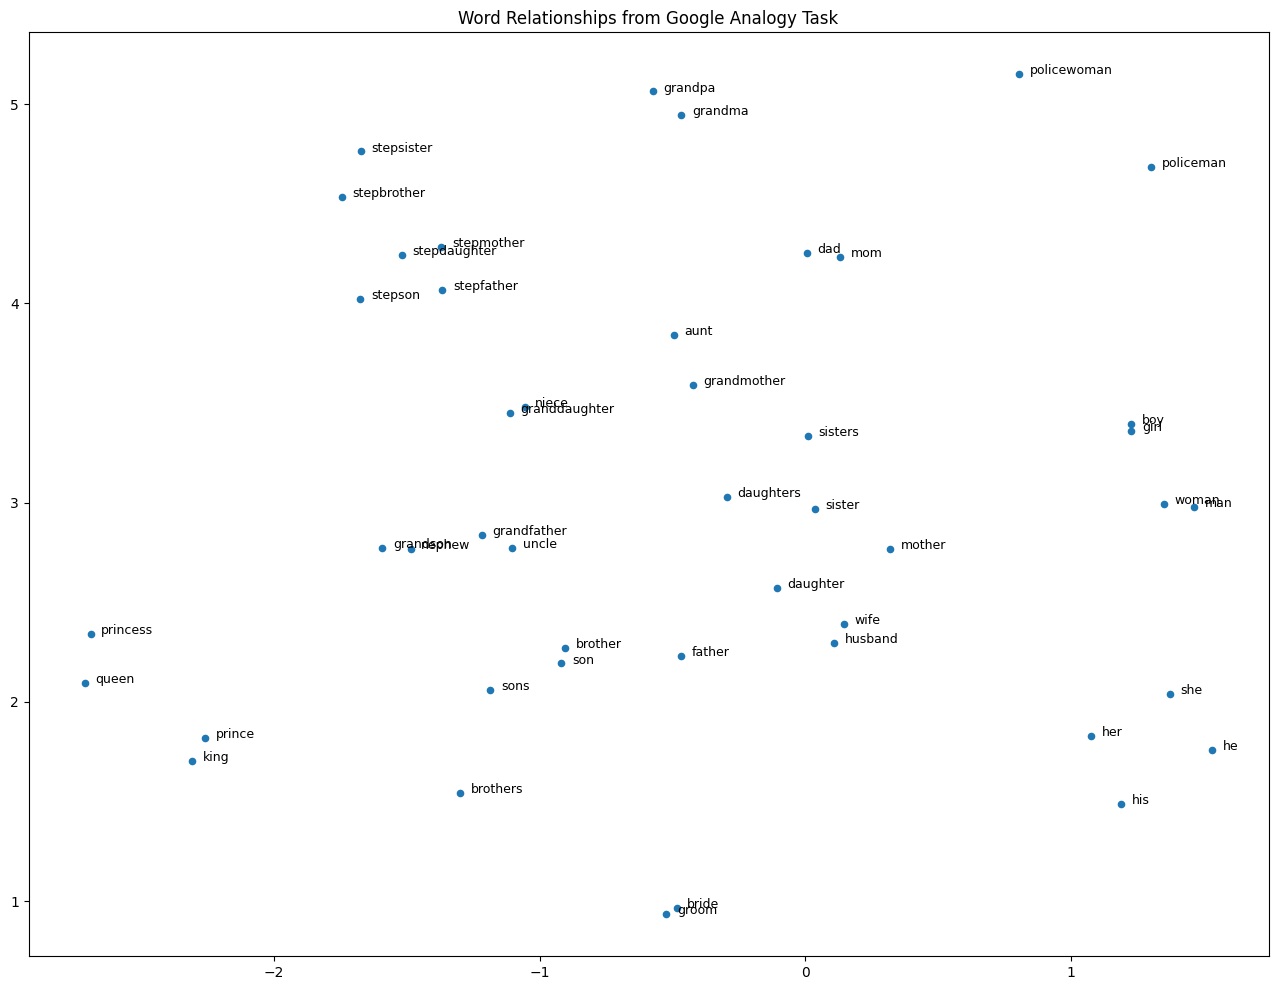

<Figure size 640x480 with 0 Axes>

In [ ]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO3: Plot t-SNE for the words in the SUB_CATEGORY `: family`
#(use Chatgpt to help write the code)
# 取出 family 子類別
sub_category_data = data[data.SubCategory == SUB_CATEGORY]
sub_category_data_str = " ".join(sub_category_data.Question)

# 先 split 再小寫 + 去重
words = np.unique(np.array(sub_category_data_str.split()))
words = [w.lower() for w in words]

# 只保留模型裡有的詞（避免 OOV）
words = [w for w in words if w in model.key_to_index]

print(f"[{SUB_CATEGORY}] words in model: {len(words)}")

# 向量矩陣
X = np.array([model[w] for w in words])

# t-SNE：perplexity 必須 < n_samples
perp = max(2, min(30, len(words) - 1))
embedded = TSNE(n_components=2, init="pca", random_state=42, perplexity=perp).fit_transform(X)

# 繪圖
plt.figure(figsize=(16, 12))
plt.scatter(embedded[:, 0], embedded[:, 1], s=20)

for idx, (x, y) in enumerate(embedded):
    plt.annotate(words[idx], (x + 0.04, y), fontsize=9)
    
plt.title("Word Relationships from Google Analogy Task")
plt.show()
plt.savefig("word_relationships.png", bbox_inches="tight")

### Part III: Train your own word embeddings

### Get the latest English Wikipedia articles and do sampling.
- Usually, we start from Wikipedia dump (https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2). However, the downloading step will take very long. Also, the cleaning step for the Wikipedia corpus ([`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus)) will take much time. Therefore, we provide cleaned files for you.

In [22]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles).
!gdown --id 1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd -O wiki_texts_part_0.txt.gz
!gdown --id 1ABblLRd9HXdXvaNv8H9fFq984bhnowoG -O wiki_texts_part_1.txt.gz
!gdown --id 1z2VFNhpPvCejTP5zyejzKj5YjI_Bn42M -O wiki_texts_part_2.txt.gz
!gdown --id 1VKjded9BxADRhIoCzXy_W8uzVOTWIf0g -O wiki_texts_part_3.txt.gz
!gdown --id 16mBeG26m9LzHXdPe8UrijUIc6sHxhknz -O wiki_texts_part_4.txt.gz

/home/liw65961/.venvs/pyjup/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd
From (redirected): https://drive.google.com/uc?id=1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd&confirm=t&uuid=6d057514-0b7c-4e28-a05a-cf62c2dcd4d3
To: /home/liw65961/CS563100_Natural_Language_Processing/wiki_texts_part_0.txt.gz
100%|██████████████████████████████████████| 1.51G/1.51G [04:47<00:00, 5.25MB/s]
/home/liw65961/.venvs/pyjup/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ABblLRd9HXdXvaNv8H9fFq984bhnowoG
From (redirected): https://drive

In [17]:
import sys
!{sys.executable} -m pip install -U gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [gdown]


In [18]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles), except the last file.
!gdown --id 17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI -O wiki_texts_part_5.txt.gz
!gdown --id 19IvB2vOJRGlrYulnTXlZECR8zT5v550P -O wiki_texts_part_6.txt.gz
!gdown --id 1sjwO8A2SDOKruv6-8NEq7pEIuQ50ygVV -O wiki_texts_part_7.txt.gz
!gdown --id 1s7xKWJmyk98Jbq6Fi1scrHy7fr_ellUX -O wiki_texts_part_8.txt.gz
!gdown --id 17eQXcrvY1cfpKelLbP2BhQKrljnFNykr -O wiki_texts_part_9.txt.gz
!gdown --id 1J5TAN6bNBiSgTIYiPwzmABvGhAF58h62 -O wiki_texts_part_10.txt.gz

/home/liw65961/.venvs/pyjup/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI
From (redirected): https://drive.google.com/uc?id=17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI&confirm=t&uuid=5c584810-bbeb-4d8a-a1b2-75965a43d127
To: /home/liw65961/CS563100_Natural_Language_Processing/wiki_texts_part_5.txt.gz
100%|████████████████████████████████████████| 578M/578M [00:10<00:00, 56.6MB/s]
/home/liw65961/.venvs/pyjup/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=19IvB2vOJRGlrYulnTXlZECR8zT5v550P
From (redirected): https://drive

In [24]:
# Extract the downloaded wiki_texts_parts files.
!gunzip -k wiki_texts_part_*.gz

In [25]:
# Combine the extracted wiki_texts_parts files.
!cat wiki_texts_part_*.txt > wiki_texts_combined.txt

In [26]:
# Check the first ten lines of the combined file
!head -n 10 wiki_texts_combined.txt

anarchism is political philosophy and movement that is against all forms of authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy typically including the state and capitalism anarchism advocates for the replacement of the state with stateless societies and voluntary free associations as historically left wing movement this reading of anarchism is placed on the farthest left of the political spectrum usually described as the libertarian wing of the socialist movement libertarian socialism although traces of anarchist ideas are found all throughout history modern anarchism emerged from the enlightenment during the latter half of the th and the first decades of the th century the anarchist movement flourished in most parts of the world and had significant role in workers struggles for emancipation various anarchist schools of thought formed during this period anarchists have taken part in several revolutions most notably in the paris commune

Please note that we used the default parameters of [`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus) for cleaning the Wiki raw file. Thus, words with one character were discarded.

In [ ]:
import sys
print(sys.executable)  # 看你正在用哪支 Python
!{sys.executable} -m pip install -U pip setuptools wheel
!{sys.executable} -m pip install -U datasets

/home/liw65961/.venvs/pyjup/bin/python


In [31]:
from datasets import load_dataset
from gensim.utils import simple_preprocess
from pathlib import Path

ds = load_dataset("cc_news")
texts = [(ex.get("title","") + " " + ex.get("description","") + " " + ex.get("text","")).strip()
         for ex in ds["train"]]

out_path = "cc_news_sentences.txt"
with open(out_path, "w", encoding="utf-8") as f:
    for doc in texts:
        toks = simple_preprocess(doc, deacc=True, min_len=2, max_len=15)
        # toks = [t for t in toks if t.isascii() and t.isalpha()]  # 只留英文單詞
        toks = [t for t in toks]
        if toks:
            f.write(" ".join(toks) + "\n")

print("saved to:", out_path)

Generating train split: 100%|██████████| 708241/708241 [00:03<00:00, 219146.99 examples/s]


saved to: cc_news_sentences.txt


In [25]:
# Now you need to do sampling because the corpus is too big.
# You can further perform analysis with a greater sampling ratio.

import random


wiki_txt_path = "wiki_texts_combined.txt"
# wiki_texts_combined.txt is a text file separated by linebreaks (\n).
# Each row in wiki_texts_combined.txt indicates a Wikipedia article.
output_path = "wiki_texts_20pct.txt"
p = 0.2
random.seed(42)  # for reproducibility

with open(wiki_txt_path, "r", encoding="utf-8") as f:
    with open(output_path, "w", encoding="utf-8") as output_file:
    # TODO4: Sample `20%` Wikipedia articles
    # Write your code here
        for line in f:
            if random.random() < p:  # ~20% Bernoulli sampling
                output_file.write(line)

print(f"Done. Wrote ~20% to: {output_path}")

Done. Wrote ~20% to: wiki_texts_20pct.txt


In [26]:
#Preprocess the sampled corpus and train Word2Vec embeddings(use Chatgpt to help write the code)
import nltk
try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")

from nltk.corpus import stopwords
STOP_NLTK = set(stopwords.words("english"))

CUSTOM_STOP = {"wikipedia", "http", "https", "www", "category", "ref"}
KEEP = {"not", "no"}  # 想保留的否定詞
STOP = (STOP_NLTK | CUSTOM_STOP) - KEEP

In [27]:
from pathlib import Path

sampled_path = "wiki_texts_20pct.txt"

path = Path(sampled_path)  
# 計算總行數
with path.open("r", encoding="utf-8", errors="ignore") as f:
    total_lines = sum(1 for _ in f)
print(f"Total lines: {total_lines:,}")

Total lines: 1,124,733


In [28]:
# TODO5: Train your own word embeddings with the sampled articles
# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
# Hint: You should perform some pre-processing before training.
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
import multiprocessing as mp
from pathlib import Path

sampled_path = "wiki_texts_20pct.txt"

path = Path(sampled_path)  
# 計算總行數
with path.open("r", encoding="utf-8", errors="ignore") as f:
    total_lines = sum(1 for _ in f)
print(f"Total lines: {total_lines:,}")

max_lines = None  # 想全量就改 None

class SentenceIter:
    def __init__(self, path, max_lines=None):
        self.path = path
        self.max_lines = max_lines
    def __iter__(self):
        with open(self.path, "r", encoding="utf-8") as f:
            for i, line in enumerate(f):
                if self.max_lines is not None and i >= self.max_lines:
                    break
                # 先做基本清理（小寫、去標點），再只留純英文 token
                toks = simple_preprocess(line, deacc=True, min_len=2, max_len=15)
                # 只留 ASCII 英文字母，且排除 NLTK stopwords
                toks = [t for t in toks if t.isascii() and t.isalpha() and t not in STOP]
                if toks:
                    yield toks

sentences = SentenceIter(sampled_path, max_lines=max_lines)  
#sg=0用「周圍的字」去預測中心詞，速度快、較省資源；對高頻詞效果好；大語料常用作預設/baseline。sg=1用「中心詞」去預測周圍的字特性：較慢、但對低頻詞/小語料常比較好；語義/類比任務有時表現更佳。

# w2v = Word2Vec(
#     sentences=sentences,
#     vector_size=50, 
#     window=3, 
#     min_count=20,
#     sg=0, 
#     negative=5, 
#     sample=1e-3,
#     workers=max(1, mp.cpu_count()-1),
#     epochs=2, 
#     seed=42,
#     batch_words=10000,
# )
w2v = Word2Vec(
    sentences=sentences,
    vector_size=150, 
    window=10, 
    min_count=20,
    sg=0, #sg=0用「周圍的字」去預測中心詞，速度快、較省資源；對高頻詞效果好；大語料常用作預設/baseline。sg=1用「中心詞」去預測周圍的字特性：較慢、但對低頻詞/小語料常比較好；語義/類比任務有時表現更佳。
    negative=20, 
    sample=1e-3,
    workers=max(1, mp.cpu_count()-1),
    epochs=2, 
    seed=42,
    batch_words=10000,
)
model = w2v.wv
print("vocab size:", len(model.key_to_index))
model.save("word2vec_wiki_20pct_ef.model")


Total lines: 1,124,733
vocab size: 411929


In [17]:
# TODO5: Train your own word embeddings with the sampled articles
# https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
# Hint: You should perform some pre-processing before training.
from gensim.utils import simple_preprocess
from gensim.models import FastText
import multiprocessing as mp
from pathlib import Path

inp_path = "wiki_texts_20pct.txt"          # 你現有的一行一句檔
out_path = "wiki_texts_20pct_clean.txt"    # 預處理後輸出

path = Path(inp_path)  
# 計算總行數
with path.open("r", encoding="utf-8", errors="ignore") as f:
    total_lines = sum(1 for _ in f)
print(f"Total lines: {total_lines:,}")

max_lines = None  # 想全量就改 None

with open(inp_path, "r", encoding="utf-8") as fin, open(out_path, "w", encoding="utf-8") as fout:
    for line in fin:
        # simple_preprocess：小寫、去標點、長度過濾（跟你之前一致）
        toks = simple_preprocess(line, deacc=True, min_len=2, max_len=15)
        toks = [t for t in toks if t.isascii() and t.isalpha() and t not in STOP]
        if toks:
            fout.write(" ".join(toks) + "\n")

# ft = FastText(
#     corpus_file=out_path,
#     vector_size=100,     # 跟 glove-100d 對齊好比
#     window=3,
#     min_count=5,
#     sg=0,                # 建議 skip-gram（稀有詞/子詞更穩）；要更快可改 0
#     negative=10,
#     sample=1e-3,
#     workers=max(1, mp.cpu_count()-1),
#     epochs=2,
#     # 子詞參數（預設就不錯，列出給你調）
#     min_n=3, max_n=6,    # 3~6 字元的 n-gram
#     bucket=2_000_000,    # 子詞哈希桶，記憶體吃緊可下修
#     seed=42,
#     batch_words=10000
# )
ft = FastText(
    corpus_file=out_path,
    vector_size=50,     # 跟 glove-100d 對齊好比
    window=3,
    min_count=20,
    sg=0,                # 建議 skip-gram（稀有詞/子詞更穩）；要更快可改 0
    negative=5,
    sample=1e-3,
    workers=max(1, mp.cpu_count()-1),
    epochs=2,
    seed=42,
    batch_words=10000
)

model = ft.wv                       # FastTextKeyedVectors
print("vocab size:", len(model.key_to_index))
model.save("fasttext_wiki_20pct.kv")   # 儲存向量，之後載入更快

Total lines: 1,124,733


KeyboardInterrupt: 

In [4]:
import pandas as pd
data = pd.read_csv("questions-words.csv")

In [5]:
# Do predictions and preserve the gold answers (word_D)
from gensim.models import KeyedVectors
preds = []
golds = []

model = KeyedVectors.load("word2vec_wiki_20pct_ef.model")

for analogy in tqdm(data["Question"]):
      # TODO6: Write your code here to use your trained word embeddings for getting predictions of the analogy task.
      # You should also preserve the gold answers during iterations for evaluations later.
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """
      a, b, c, d = analogy.strip().split()

      # 全部轉小寫，避免 OOV
      a, b, c, d = a.lower(), b.lower(), c.lower(), d.lower()

      try:
            pred = model.most_similar(positive=[b, c], negative=[a], topn=1)[0][0]
      except KeyError:
            pred = None  # 如果還是 OOV，就跳過
      preds.append(pred)
      golds.append(d)

100%|██████████| 19544/19544 [01:51<00:00, 175.71it/s]


In [6]:
# Perform evaluations. You do not need to modify this block!!

def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds), np.array(preds)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: semantic, Accuracy: 72.73649791408276%
Category: syntatic, Accuracy: 52.374707259953155%
Sub-Category: capital-common-countries, Accuracy: 88.14229249011858%
Sub-Category: capital-world, Accuracy: 85.45534924845269%
Sub-Category: currency, Accuracy: 16.74364896073903%
Sub-Category: city-in-state, Accuracy: 65.91001216051885%
Sub-Category: family, Accuracy: 72.72727272727273%
Sub-Category: gram1-adjective-to-adverb, Accuracy: 17.540322580645164%
Sub-Category: gram2-opposite, Accuracy: 17.24137931034483%
Sub-Category: gram3-comparative, Accuracy: 64.63963963963964%
Sub-Category: gram4-superlative, Accuracy: 36.898395721925134%
Sub-Category: gram5-present-participle, Accuracy: 44.60227272727273%
Sub-Category: gram6-nationality-adjective, Accuracy: 85.92870544090057%
Sub-Category: gram7-past-tense, Accuracy: 53.58974358974359%
Sub-Category: gram8-plural, Accuracy: 67.64264264264264%
Sub-Category: gram9-plural-verbs, Accuracy: 48.275862068965516%


[: family] words in model: 42


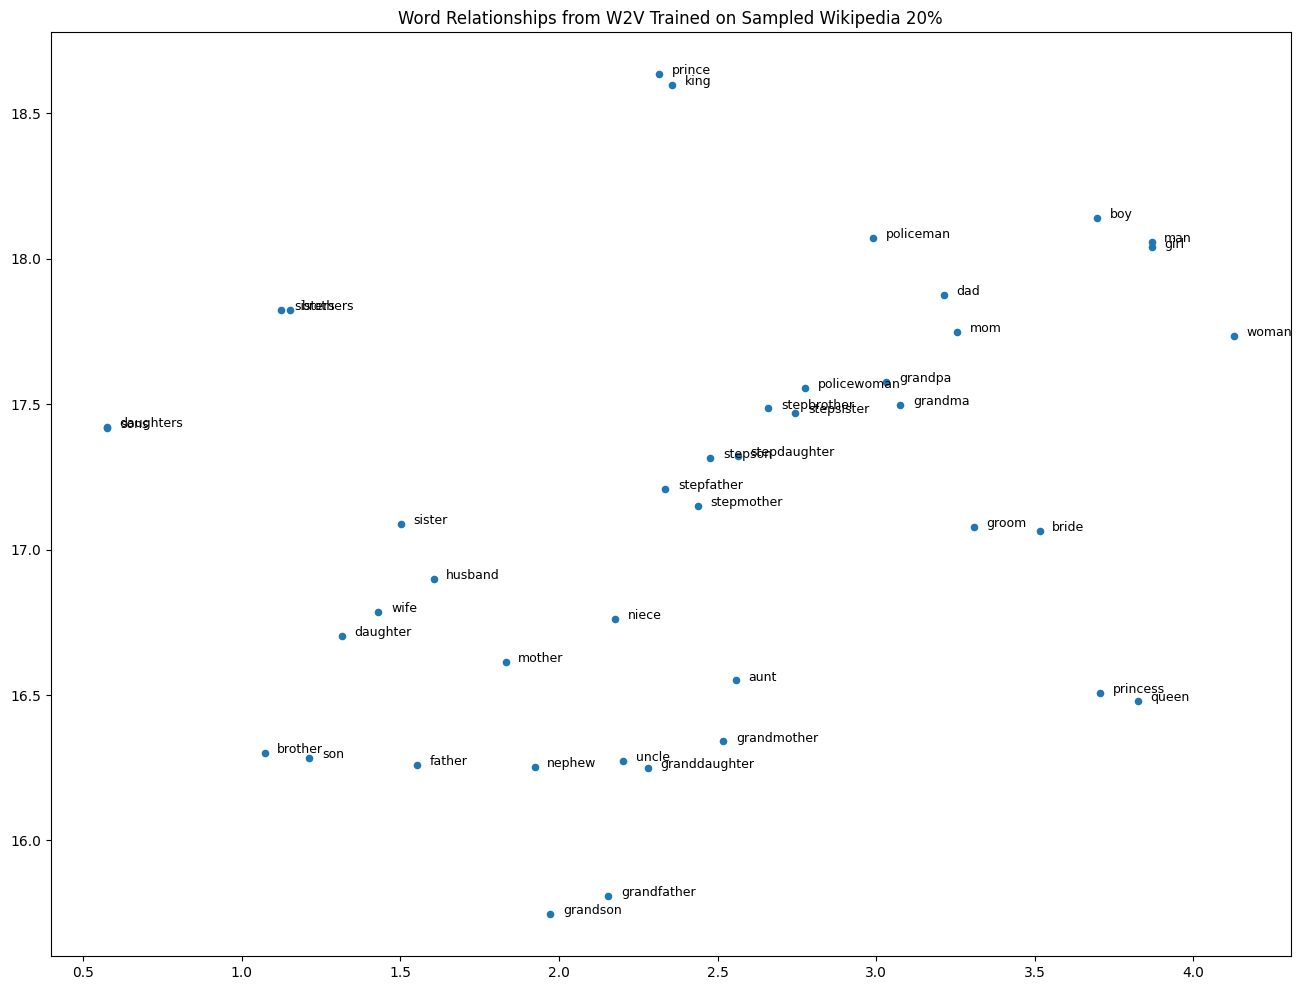

In [ ]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO7: Plot t-SNE for the words in the SUB_CATEGORY `: family`
#(use Chatgpt to help write the code)
# 取出 family 子類別
sub_category_data = data[data.SubCategory == SUB_CATEGORY]
sub_category_data_str = " ".join(sub_category_data.Question)

# 先 split 再小寫 + 去重
words = np.unique(np.array(sub_category_data_str.split()))
words = [w.lower() for w in words]

# 只保留模型裡有的詞（避免 OOV）
words = [w for w in words if w in model.key_to_index]

print(f"[{SUB_CATEGORY}] words in model: {len(words)}")

# 向量矩陣
X = np.array([model[w] for w in words])

# t-SNE：perplexity 必須 < n_samples
perp = max(2, min(30, len(words) - 1))
embedded = TSNE(n_components=2, init="pca", random_state=42, perplexity=perp).fit_transform(X)

# 繪圖
plt.figure(figsize=(16, 12))
plt.scatter(embedded[:, 0], embedded[:, 1], s=20)

for idx, (x, y) in enumerate(embedded):
    plt.annotate(words[idx], (x + 0.04, y), fontsize=9)


plt.title("Word Relationships from W2V Trained on Sampled Wikipedia 20%")
plt.savefig("word_relationships_own.png", bbox_inches="tight")
plt.show()

In [21]:
from gensim.models import KeyedVectors

model = KeyedVectors.load("word2vec_cc_news.model")
def top5_similar(q, model):
    q0 = q.lower().strip()         
    try:
        vec = model.get_vector(q0) 
        return [w for w, _ in model.most_similar(vec, topn=5)]
    except KeyError:
        return ["vocabulary not in model"]  

queries = ["paris", "handsome", "run", "singing", "zebra"]
for q in queries:
    print(q, "→", top5_similar(q, model))


paris → ['paris', 'berlin', 'france', 'rome', 'vienna']
handsome → ['handsome', 'badass', 'hunky', 'hunk', 'charming']
run → ['run', 'stretch', 'runs', 'running', 'finish']
singing → ['singing', 'sing', 'sang', 'dancing', 'dance']
zebra → ['zebra', 'snails', 'hummingbird', 'dandelion', 'moth']
